<center>
<img src="https://drive.google.com/uc?id=1f1gGVI-rxcHjA90WEGNvvtSXF1pAxQwg" alt="Fasilkom UI" width="300"/>

CSCE604133 - Pengolahan Citra

Semester Ganjil 2023/2024

Fakultas Ilmu Komputer, Universitas Indonesia

## Image Binary Segmentation: *Eschickon Wheat Segmentation*

### **Tenggat Waktu: 10 Desember 2023, 23.55 WIB**

### Kelompok B4:
Madeleine Sekar Putri W <br>
Jason Widodo <br>
Kevin <br>
Ezra Pasha Ramadhansyah <br>
Francois Ferdinand Dahny Ginting <br>
</center>

### Import Library

In [1]:
import os
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
from scipy import fftpack as fp
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.morphology import disk, square, diamond, erosion, dilation, opening, closing, white_tophat, black_tophat
from keras.layers import (
    Conv2D,
    BatchNormalization,
    Activation,
    Concatenate,
    Input,
    Dropout,
)
from keras.layers import (
    AveragePooling2D,
    GlobalAveragePooling2D,
    UpSampling2D,
    Reshape,
    Dense,
)
from keras.models import Model
from keras.applications import ResNet50, ResNet101
from keras.regularizers import l2
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.image import ResizeMethod, resize
from keras.callbacks import (
    ModelCheckpoint,
    CSVLogger,
    ReduceLROnPlateau,
    EarlyStopping,
    TensorBoard,
)
from keras.optimizers import Adam
from keras.metrics import Recall, Precision, Accuracy
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('float32')

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

# Dataset

Dataset yang digunakan adalah dataset Eschickon Wheat Segmentation. Dataset ini diambil dari sumber https://datasetninja.com/eschikon-wheat-segmentation#download.

Dataset ini terdiri dari 190 image teranotasi yang memiliki 1 kelas yaitu `plant`. Dataset displit menjadi 3 dataset, yaitu `train` (142 images), `test` (24 images), dan `validation` (24 images). Dataset ini dirilis oleh ETH Zurich, Switzerland pada tahun 2021.

In [40]:
dataset_path = os.path.join('dataset', 'EWS-Dataset')
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')
validation_path = os.path.join(dataset_path, 'validation')

# divide image and mask path
train_image_path = os.path.join(train_path, 'Images')
train_mask_path = os.path.join(train_path, 'Masks')

test_image_path = os.path.join(test_path, 'Images')
test_mask_path = os.path.join(test_path, 'Masks')

validation_image_path = os.path.join(validation_path, 'Images')
validation_mask_path = os.path.join(validation_path, 'Masks')


In [14]:
def load_dataset(image_paths, mask_paths):
    images = [cv2.imread(path) for path in image_paths]
    masks = [cv2.imread(path, 0) for path in mask_paths]  # Load masks as grayscale
    return images, masks

# get all train and test image and mask paths
train_image_paths = [ os.path.join(train_image_path, filename) for filename in os.listdir(train_image_path) ]
train_mask_paths = [ os.path.join(train_mask_path, filename) for filename in os.listdir(train_mask_path) ]

test_image_paths = [ os.path.join(test_image_path, filename) for filename in os.listdir(test_image_path) ]
test_mask_paths = [ os.path.join(test_mask_path, filename) for filename in os.listdir(test_mask_path) ]

validation_image_paths = [ os.path.join(validation_image_path, filename) for filename in os.listdir(validation_image_path) ]
validation_mask_paths = [ os.path.join(validation_mask_path, filename) for filename in os.listdir(validation_mask_path) ]

# load train and test dataset
train_images, train_masks = load_dataset(train_image_paths, train_mask_paths)
test_images, test_masks = load_dataset(test_image_paths, test_mask_paths)

# load validation dataset
validation_images, validation_masks = load_dataset(validation_image_paths, validation_mask_paths)

In [15]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR).astype(np.float32)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0  # normalizing and standardizing image with Imagenet specifications
    x -= MEAN
    x /= STD
    return x


def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0  # normalizing mask
    x = np.expand_dims(x, axis=-1)
    return x

# Image Preprocessing

In [16]:
def preprocess(images, masks, size=(256, 256)):
    images = [cv2.resize(image, size) for image in images]
    masks = [cv2.resize(mask, size) for mask in masks]
    return images, masks

# Extract features
def extract_features(images):
    features = []
    for image in images:
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Apply Gaussian blur
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        # Edge detection
        edges = cv2.Canny(blur, 50, 150)
        # Flatten and add to features
        features.append(edges.flatten())
    return features

# Image Segmentation Pendekatan Konvensional

In [38]:
# Apply CIVE algorithm to each image in the dataset
cive_segmented_train_images = []

train_images_features = extract_features(train_images)

for image in train_images:
    # Split the image into its RGB channels
    red_channel = image[:, :, 2]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 0]

    # Apply the CIVE algorithm
    cive_image = 0.441 * red_channel - 0.880 * green_channel + 0.385 * blue_channel + 19.78745

    # Apply the COM2 algorithm
    com2_image = 0.5 * (2 * red_channel - green_channel - blue_channel) / (red_channel + green_channel + blue_channel)

    # Threshold the CIVE image to obtain the segmented image
    _, cive_thresholded_image = cv2.threshold(cive_image, 0, 255, cv2.THRESH_BINARY)

    # Threshold the COM2 image to obtain the segmented image
    _, com2_thresholded_image = cv2.threshold(com2_image, 0, 255, cv2.THRESH_BINARY)

    thresholded_image = cv2.bitwise_and(cive_thresholded_image, com2_thresholded_image)

    # Append to the list of segmented images
    cive_segmented_train_images.append(thresholded_image)


C:\Users\DELL\AppData\Local\Temp\ipykernel_9752\1378360356.py:16: RuntimeWarning: divide by zero encountered in divide
  com2_image = 0.5 * (2 * red_channel - green_channel - blue_channel) / (red_channel + green_channel + blue_channel)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9752\1378360356.py:16: RuntimeWarning: invalid value encountered in divide
  com2_image = 0.5 * (2 * red_channel - green_channel - blue_channel) / (red_channel + green_channel + blue_channel)


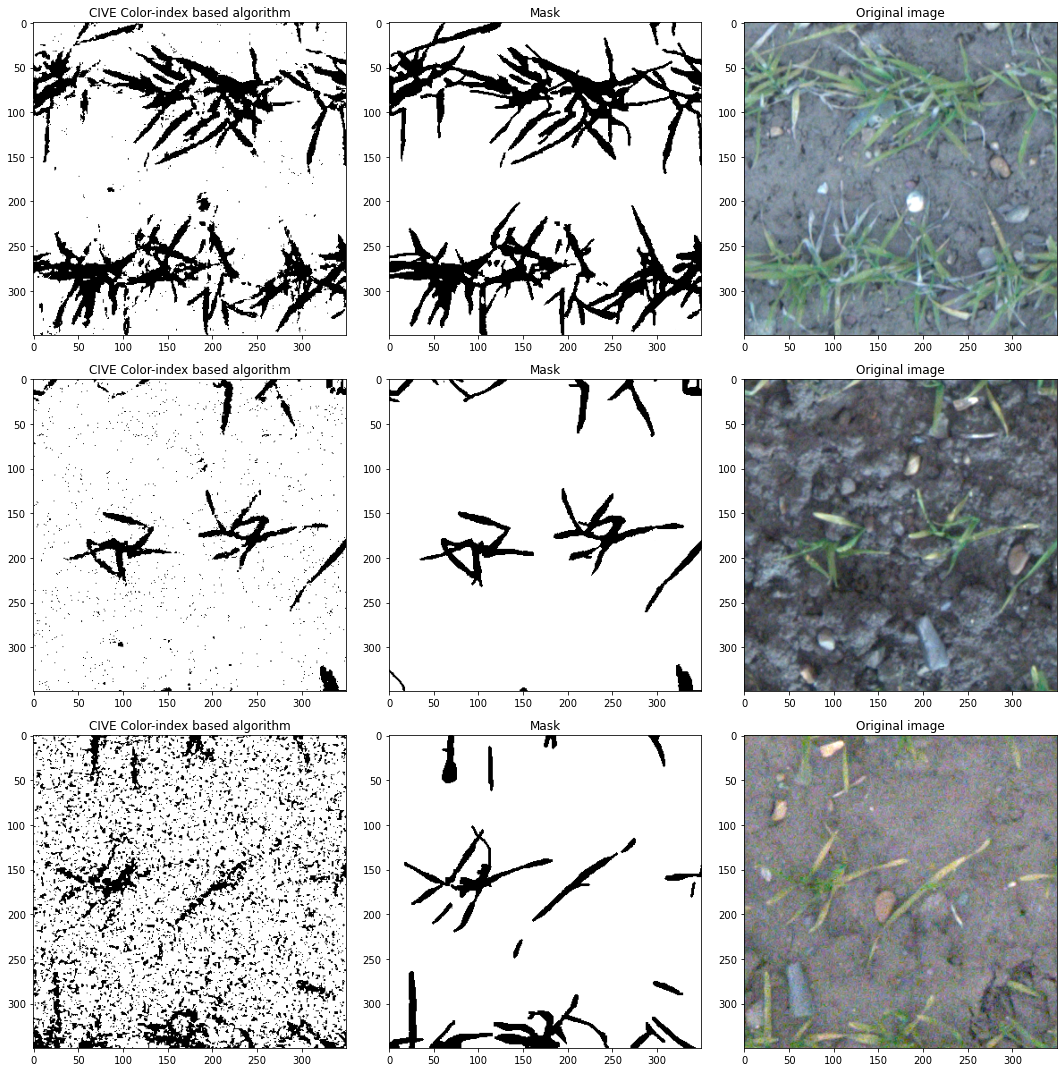

In [39]:
# output 3 samples of the otsu's thresholding images and compare them with it's mask and original images
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# First row
axes[0, 0].imshow(cive_segmented_train_images[0], cmap='gray')
axes[0, 0].set_title('CIVE Color-index based algorithm')
axes[0, 1].imshow(train_masks[0], cmap='gray')
axes[0, 1].set_title('Mask')
axes[0, 2].imshow(train_images[0], cmap='gray')
axes[0, 2].set_title('Original image')

# Second row
axes[1, 0].imshow(cive_segmented_train_images[1], cmap='gray')
axes[1, 0].set_title('CIVE Color-index based algorithm')
axes[1, 1].imshow(train_masks[1], cmap='gray')
axes[1, 1].set_title('Mask')
axes[1, 2].imshow(train_images[1], cmap='gray')
axes[1, 2].set_title('Original image')

# Third row
axes[2, 0].imshow(cive_segmented_train_images[2], cmap='gray')
axes[2, 0].set_title('CIVE Color-index based algorithm')
axes[2, 1].imshow(train_masks[2], cmap='gray')
axes[2, 1].set_title('Mask')
axes[2, 2].imshow(train_images[2], cmap='gray')
axes[2, 2].set_title('Original image')

plt.tight_layout()
plt.show()


# Image Segmentation Pendekatan Deep Learning
Menggunakan model yang dipublikasikan oleh Surehli, et al. pada link https://github.com/mukund-ks/DeepLabV3-Segmentation, dan disesuaikan dengan kebutuhan dan spesifikasi proyek kami sebagai berikut.

In [19]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from typing import Any, Union

H = 256
W = 256
LR = 2e-4

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


def createDir(path: str) -> None:
    """Helper function to create a directory.

    Args:
        path (str): Path to create.
    """
    if not os.path.exists(path):
        os.makedirs(path)
    return


def loadData(path: str) -> list[str]:
    """Helper function to load data in lists from a directory.

    Args:
        path (str): Path to Data Directory.

    Raises:
        OSError: In case the Data Directory provided does not exist.

    Returns:
        list[str]: List of Images and Masks.
    """
    x = sorted(glob(os.path.join(path, "Image", "*png")))
    y = sorted(glob(os.path.join(path, "Mask", "*png")))
    if len(x) == 0 or len(y) == 0:
        raise OSError("No Input in provided Directory.")
    return x, y


def shuffling(x: list[str], y: list[str]) -> list[str]:
    """Helper function to shuffle training set.

    Args:
        x (list[str]): Images
        y (list[str]): Masks

    Returns:
        list[str]: Shuffled list of images and masks.
    """
    x, y = shuffle(x, y, random_state=42)
    return x, y



def createDirs(paths: tuple[str]) -> None:
    """Helper function to create a set of directories.

    Args:
        paths (tuple[str]): Tuple containing paths.
    """
    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path)
    return


def getMaskLen(y_pred: np.ndarray) -> Union[float, int]:
    """Determines a bounding box around the predicted mask and returns diagonal, horizontal and vertical length of the box in pixels

    Args:
        y_pred (numpy.ndarray): Binary mask from model prediction

    Returns:
        float | int: diagonal, horizontal & vertical length
    """
    binary_mask = np.array(y_pred, dtype=np.uint8)

    # Finding Contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Getting the Largest Contour
    try:
        largest_contour = max(contours, key=cv2.contourArea)
    except Exception as _:
        return 0.0, 0.0, 0.0

    # Getting the co-ordinates for smalles possible Bounding Box
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Calculating line lengths
    diagonal_length = round(np.sqrt(w**2 + h**2), 2)
    horizontal_length = round(w, 2)
    vertical_length = round(h, 2)

    return diagonal_length, horizontal_length, vertical_length


def saveResults(img: np.ndarray, mask: np.ndarray, y_pred: np.ndarray, save_img_path: str) -> None:
    """Helper function to save evaluation results as a single png, with provided image, ground truth, predicted mask and segmented output, from left to right.

    Args:
        img (np.ndarray): Input Image
        mask (np.ndarray): Ground Truth
        y_pred (np.ndarray): Predicted Mask
        save_img_path (str): Directory to save the results in.
    """
    line = np.ones((H, 10, 3)) * 128

    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)
    # mask = mask * 255

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

    masked_img = img * y_pred
    y_pred = y_pred * 255

    imgs = np.concatenate([img, line, mask, line, y_pred, line, masked_img], axis=1)
    cv2.imwrite(save_img_path, imgs)

    return


def tmp_cleanup() -> None:
    """Utility function for ens_train.py to delete temporary images and masks.
    """
    for dir in os.listdir("./tmp/data"):
        if not os.path.isdir(os.path.join("./tmp/data", dir)):
            continue
        for filename in os.listdir(os.path.join("./tmp/data", dir)):
            if not (filename.startswith("tmp") and filename.endswith(".png")):
                continue
            file_path = os.path.join("./tmp/data", dir, filename)
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        print(f"Deleted temporary files in ./tmp/data/{dir}\n")
    return

Adapun Model yang didefinisikan adalah sebagai berikut:

In [20]:
def squeeze_and_excite(inputs: KerasTensor, ratio: int = 8) -> KerasTensor:
    """Function to apply Squeeze & Excitation to a feature map.

    Args:
        inputs (KerasTensor): Feature Map
        ratio (int, optional): Ratio for excitation in first dense layer. Defaults to 8.

    Returns:
        KerasTensor: Re-calibrated feature map.
    """
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(
        filters // ratio,
        activation="relu",
        kernel_initializer="he_normal",
        use_bias=False,
    )(se)
    se = Dense(
        filters,
        activation="sigmoid",
        kernel_initializer="he_normal",
        use_bias=False,
    )(se)

    x = init * se
    return x


def ASPP(inputs: KerasTensor) -> KerasTensor:
    """Function to apply Atrous Spatial Pyramid Pooling on features from backbone.

    Args:
        inputs (KerasTensor): Features from backbone.

    Returns:
        KerasTensor: Features with better spatial context.
    """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    # 1x1 Convolution
    y2 = Conv2D(256, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(inputs)
    y2 = BatchNormalization()(y2)
    # y2 = Dropout(0.5)(y2)
    y2 = Activation("relu")(y2)

    # 3x3 Convolution, Dilation Rate - 12 or 6
    y3 = Conv2D(
        256, 3, padding="same", dilation_rate=6, use_bias=False, kernel_initializer="he_normal"
    )(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    # 3x3 Convolution, Dilation Rate - 24 or 12
    y4 = Conv2D(
        256, 3, padding="same", dilation_rate=12, use_bias=False, kernel_initializer="he_normal"
    )(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    # 3x3 Convolution, Dilation Rate - 36 or 18
    y5 = Conv2D(
        256, 3, padding="same", dilation_rate=18, use_bias=False, kernel_initializer="he_normal"
    )(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    # 1x1 Convolution on the concatenated Feature Map
    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(256, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y


def createModel(modelType: str, shape: tuple[int] = (256, 256, 3)) -> Model:
    """Creates a Model with the specified backbone.

    Args:
        modelType (str): Choice of backbone. ResNet50 or ResNet101.
        shape (tuple[int]): Shape of input to the model. Defaults to (256, 256, 3).

    Returns:
        Model: Your DeepLabV3+ Model.
    """
    inputs = Input(shape)  # instantiating a tensor

    encoder = (
        ResNet101(weights="imagenet", include_top=False, input_tensor=inputs)
        if modelType == "ResNet101"
        else ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)
    )

    image_features = encoder.get_layer(
        "conv4_block23_out" if modelType == "ResNet101" else "conv4_block6_out"
    ).output

    # High-Level Features
    x_a = ASPP(image_features)
    # Up-Sampling High-Level Features by 4
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)
    x_a = Dropout(0.5)(x_a)

    # Low-Level Features
    x_b = encoder.get_layer("conv2_block2_out").output

    # 1x1 Convolution on Low-Level Features
    x_b = Conv2D(
        filters=48, kernel_size=1, padding="same", use_bias=False, kernel_initializer="he_normal"
    )(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation("relu")(x_b)

    # Concatenating High-Level and Low-Level Features
    x = Concatenate()([x_a, x_b])
    x = Dropout(0.5)(x)
    # x = squeeze_and_excite(x)

    # 3x3 Convolution on Concatenated Map
    x = Conv2D(
        filters=256, kernel_size=3, padding="same", use_bias=False, kernel_initializer="he_normal"
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = squeeze_and_excite(x)

    # 3x3 Convolution on Concatenated Map
    x = Conv2D(
        filters=256, kernel_size=3, padding="same", use_bias=False, kernel_initializer="he_normal"
    )(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.5)(x)
    x = Activation("relu")(x)
    x = squeeze_and_excite(x)

    # Final Up-Sampling by 4
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x = Conv2D(1, 1)(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)

    return model

Adapun *metric-metric* yang bisa digunakan untuk mengevaluasi model didefinisikan sebagai berikut:

In [21]:
import numpy as np
import tensorflow as tf
from keras.layers import Flatten

SMOOTH = 1e-15


def iou(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + SMOOTH) / (union + SMOOTH)
        x = x.astype(np.float32)
        return x

    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


def dice_coef(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = Flatten()(y_true)
    y_pred = Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2.0 * intersection + SMOOTH) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + SMOOTH)


def calc_loss(model: tf.keras.Model) -> float:
    def dice_loss(y_true: np.ndarray, y_pred: np.ndarray, l2_weight: float = 1e-8):
        dice = dice_coef(y_true, y_pred)
        l2_loss = tf.add_n([l2_weight * tf.nn.l2_loss(var) for var in model.trainable_weights])
        return 1.0 - dice + l2_loss

    return dice_loss


# Evaluation Metrics


def eval_iou(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate Intersection over Union (IoU) for binary masks.

    Parameters:
    y_true (numpy.ndarray): Ground truth binary mask (0 to 255).
    y_pred (numpy.ndarray): Predicted binary mask (0 or 1).

    Returns:
    float: IoU score.
    """
    y_true[y_true > 0] = 1  # normalize binary mask
    y_true = y_true.astype(np.float32)

    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection

    x = (intersection + SMOOTH) / (union + SMOOTH)
    x = x.astype(np.float32)
    return x


def eval_dice_coef(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate the Dice Coefficient for binary masks.

    Parameters:
    y_true (numpy.ndarray): Ground truth binary mask (0 to 255).
    y_pred (numpy.ndarray): Predicted binary mask (0 or 1).

    Returns:
    float: Dice Coefficient score.
    """
    y_true[y_true > 0] = 1  # normalize binary mask
    y_true = y_true.astype(np.float32)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)

    if union == 0:
        return 1.0  # Handle the case where both masks are empty

    dice = (2.0 * intersection + SMOOTH) / (union + SMOOTH)
    return dice


def accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate the Accuracy score for binary classification.

    Parameters:
    y_true (numpy.ndarray): Ground truth binary labels (0 to 255).
    y_pred (numpy.ndarray): Predicted binary labels (0 or 1).

    Returns:
    float: Accuracy score.
    """
    y_true[y_true > 0] = 1  # normalize binary mask
    y_true = y_true.astype(np.float32)

    correct = np.sum(y_true == y_pred)
    total = y_true.size
    accuracy = correct / total

    return accuracy


def precision_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate the Precision score for binary classification.

    Parameters:
    y_true (numpy.ndarray): Ground truth binary labels (0 to 255).
    y_pred (numpy.ndarray): Predicted binary labels (0 or 1).

    Returns:
    float: Precision score.
    """
    y_true[y_true > 0] = 1  # normalize binary mask
    y_true = y_true.astype(np.float32)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))

    if TP + FP == 0:
        return 1.0  # case where both TP and FP are zero

    precision = TP / (TP + FP)

    return precision


def recall_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate the Recall (Sensitivity) score for binary classification.

    Parameters:
    y_true (numpy.ndarray): Ground truth binary labels (0 to 255).
    y_pred (numpy.ndarray): Predicted binary labels (0 or 1).

    Returns:
    float: Recall (Sensitivity) score.
    """
    y_true[y_true > 0] = 1  # normalize binary mask
    y_true = y_true.astype(np.float32)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    if TP + FN == 0:
        return 1.0  # case where TP and FN are zero

    recall = TP / (TP + FN)
    return recall


def f1_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate the F1 Score for binary classification.

    Parameters:
    y_true (numpy.ndarray): Ground truth binary labels (0 to 255).
    y_pred (numpy.ndarray): Predicted binary labels (0 or 1).

    Returns:
    float: F1 Score.
    """
    y_true[y_true > 0] = 1  # normalize binary mask
    y_true = y_true.astype(np.float32)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    if precision + recall == 0:
        return 0.0  # Handle the case where both precision and recall are zero

    f1 = 2 * (precision * recall) / (precision + recall)
    return f1


In [41]:
def tf_parse(x: Any, y: Any) -> Any:
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X: Any, Y: Any, batch: int = 2) -> Any:
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

def trainer(
    stop_early: bool,
    batches: int,
    epochs: int,
    modelType: str,
) -> None:
    """Function to train the model.

    Args:
        stop_early (bool): Opt-in to use Early-Stopping during training.
        batches (int): No. of batches.
        epochs (int): No. of epochs.
        modelType (str): Choice of backbone. ResNet50 or ResNet101.
    """
    np.random.seed(42)
    tf.random.set_seed(42)

    createDir("output")
    files_dir = "output"

    model_path = os.path.join(files_dir, "model.h5")
    csv_path = os.path.join(files_dir, "Epoch_Log.csv")


    x_train, y_train = loadData(train_path)
    x_train, y_train = shuffling(x_train, y_train)
    x_val, y_val = loadData(validation_path)

    print(f"Train:\nImages: {len(x_train)}\tMasks: {len(y_train)}")
    print(f"Validation:\nImages: {len(x_val)}\tMasks: {len(y_val)}")

    train_dataset = tf_dataset(x_train, y_train, batch=batches)
    val_dataset = tf_dataset(x_val, y_val, batch=batches)

    model = createModel(shape=(H, W, 3), modelType=modelType)

    loss_fn = calc_loss(model=model)

    model.compile(
        loss=loss_fn,
        optimizer=Adam(LR),
        metrics=[dice_coef, iou, Recall(), Precision(), Accuracy()],
    )

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-8, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(log_dir="logs"),
    ]

    if stop_early:
        callbacks.append(
            EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=False),
        )

    print(f"\nUsing {modelType} as Encoder{' with Early Stopping.' if stop_early else '.'}\n")

    model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
    return

In [42]:
trainer(stop_early=True, batches=2, epochs=50, modelType="ResNet50")

OSError: No Input in provided Directory.

# Referensi
Surehli, M. K., Aggarwal, N., & Joshi, G. (2023, August 7). GitHub - mukund-ks/DeepLabV3-Segmentation: A DeepLab V3+ Model with ResNet 50 / ResNet101 Encoder for Binary Segmentation. Implemented with Tensorflow. Retrieved from https://github.com/mukund-ks/DeepLabV3-Segmentation
